# **VR EEG Emotion Classification**

# **1. Importing Library and Dataset**

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ASR (Artifact Subspace Reconstruction)
# Keep this robust so the notebook runs even if `meegkit` isn't installed yet.
try:
    from meegkit.asr import ASR  # pip install meegkit
except Exception as _asr_import_err:
    ASR = None
    print("ASR unavailable (missing or broken 'meegkit'):", _asr_import_err)


def ensure_asr():
    """Ensure `meegkit.asr.ASR` is importable; installs meegkit if needed."""
    global ASR
    if ASR is not None:
        return ASR

    import sys
    import subprocess

    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "meegkit"])
    from meegkit.asr import ASR as _ASR

    ASR = _ASR
    return ASR


from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize, RobustScaler
from sklearn.metrics import (
    auc,
    roc_curve,
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
 )
from sklearn.svm import LinearSVC, SVC
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from keras import Sequential, Model
from keras.layers import (
    Add,
    LSTM,
    Input,
    Dense,
    Layer,
    Conv1D,
    Conv2D,
    Flatten,
    Dropout,
    Reshape,
    Activation,
    SimpleRNN,
    Embedding,
    Bidirectional,
    DepthwiseConv2D,
    SeparableConv2D,
    AveragePooling2D,
    LayerNormalization,
    MultiHeadAttention,
    BatchNormalization,
    GlobalAveragePooling1D,
 )
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.regularizers import l2

In [33]:
csvfile = pd.read_csv('dataset.csv')

# **2. Exploratory Data Analysis (EDA)**

## 2.1 Data Cleaning and Missing/Error Values

### 2.1.1 Understanding the dataset

Understanding the dimensions and finding out errors.

***Dataset***

In [34]:
csvfile

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,p1,Calm,848.1685,838.49817,861.8681,865.4945
1,p1,Calm,840.5128,851.79486,847.3626,844.94507
2,p1,Calm,819.9634,823.18680,815.5311,833.2601
3,p1,Calm,838.0952,842.12450,848.97437,850.58606
4,p1,Calm,849.7802,849.78020,829.6337,838.49817
...,...,...,...,...,...,...
19003,p9,Bored,865.89746,836.48350,858.24176,877.1795
19004,p9,Bored,874.7619,857.43590,831.2454,896.9231
19005,p9,Bored,906.99634,897.72894,925.5311,939.6337
19006,p9,Bored,795.38464,823.99270,979.12085,731.7216


***Information***

In [35]:
csvfile.info()

<class 'pandas.DataFrame'>
RangeIndex: 19008 entries, 0 to 19007
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Participant     19008 non-null  str    
 1   Classification  19008 non-null  str    
 2   RAW_TP9         19008 non-null  str    
 3   RAW_AF7         19008 non-null  float64
 4   RAW_AF8         19008 non-null  str    
 5   RAW_TP10        19008 non-null  str    
dtypes: float64(1), str(5)
memory usage: 891.1 KB


***Determining Numerical Features***

In [36]:
numerical_data = csvfile.select_dtypes(include='number')

numerical_features = numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 1 numerical features: 

['RAW_AF7']


Only one numerical features is not correct

***Checking `null` values***

In [37]:
csvfile.isnull().sum()

Participant       0
Classification    0
RAW_TP9           0
RAW_AF7           0
RAW_AF8           0
RAW_TP10          0
dtype: int64

***Checking `#NUM!` values***

In [38]:
(csvfile == "#NUM!").sum()

Participant        0
Classification     0
RAW_TP9           13
RAW_AF7            0
RAW_AF8           10
RAW_TP10          19
dtype: int64

In [39]:
# Basic cleaning for EDA only (no learned statistics)

#

# IMPORTANT (P2 workflow): we keep cleaning lightweight here so EDA plots work.

# Strict cleaning (coercing EEG columns to float + dropping invalid rows) is done

# inside the feature-extraction cell before train/test splitting.



# Mark obvious invalid numeric strings as NaN (does not use any global statistics)

csvfile = csvfile.replace('#NUM!', np.nan)



# Coerce EEG columns to numeric so EDA cells work (does not fit/learn anything)

eeg_cols = ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']

for c in eeg_cols:

    if c in csvfile.columns:

        csvfile[c] = pd.to_numeric(csvfile[c], errors='coerce')



print('After basic cleaning (no global drop):', csvfile.shape)

print('NaNs per EEG column:', csvfile[eeg_cols].isna().sum().to_dict() if all(c in csvfile.columns for c in eeg_cols) else 'missing eeg cols')

print('Dtypes:', {k: str(v) for k, v in csvfile.dtypes.to_dict().items()})


After basic cleaning (no global drop): (19008, 6)
NaNs per EEG column: {'RAW_TP9': 13, 'RAW_AF7': 0, 'RAW_AF8': 10, 'RAW_TP10': 19}
Dtypes: {'Participant': 'str', 'Classification': 'str', 'RAW_TP9': 'float64', 'RAW_AF7': 'float64', 'RAW_AF8': 'float64', 'RAW_TP10': 'float64'}


In [40]:
numerical_data = csvfile.select_dtypes(include='number')

numerical_features = numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 4 numerical features: 

['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']


### 2.1.3 Dataset Analysis

***Categorical Features***

In [41]:
categorical_data=csvfile.select_dtypes(include= 'object')

categorical_features=categorical_data.columns.tolist()

print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 2 categorical features: 

['Participant', 'Classification']


/tmp/ipykernel_77570/2333154239.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_data=csvfile.select_dtypes(include= 'object')


***Transposed Stats of Numerical Features***

In [42]:
numerical_data.describe().T

,count,mean,std,min,25%,50%,75%,max
RAW_TP9,18995.0,841.601336,95.377287,0.000000,822.38100,844.94507,864.28570,1650.0
RAW_AF7,19008.0,851.929095,73.676821,8.058608,836.08057,850.98900,865.09155,1650.0
RAW_AF8,18998.0,850.789877,170.856288,0.000000,830.03660,850.18317,869.52380,1650.0
RAW_TP10,18989.0,840.564233,107.157999,0.402930,821.17220,844.94507,864.68866,1650.0


***Transposed Stats of Categorical Features***

In [43]:
categorical_data.describe().T

,count,unique,top,freq
Participant,19008,31,p4,625
Classification,19008,4,Happy,4791


***Unique Values in Numerical Features***

In [44]:
numerical_data.nunique()

RAW_TP9     1420
RAW_AF7     1264
RAW_AF8     2058
RAW_TP10    1533
dtype: int64

***Unique Values in Categorical Features***

In [45]:
unique_counts=categorical_data.nunique()
print(unique_counts)

Participant       31
Classification     4
dtype: int64


## 2.2 Class Distribution / Imbalance

### 2.2.1 Variance

In [46]:
numerical_data = csvfile.select_dtypes(include='number')
numerical_features=numerical_data.columns.tolist()
numerical_data.var()

RAW_TP9      9096.826928
RAW_AF7      5428.273991
RAW_AF8     29191.871296
RAW_TP10    11482.836803
dtype: float64

**RAW_AF8  - Noisiest i.e. Most Active <br>
RAW_AF7  - Quietist i.e. Most Stable <br>
RAW_TP9  - Moderate Activity <br>
RAW_TP10 - Moderate Activity**

### 2.2.2 Distribution of Emotions

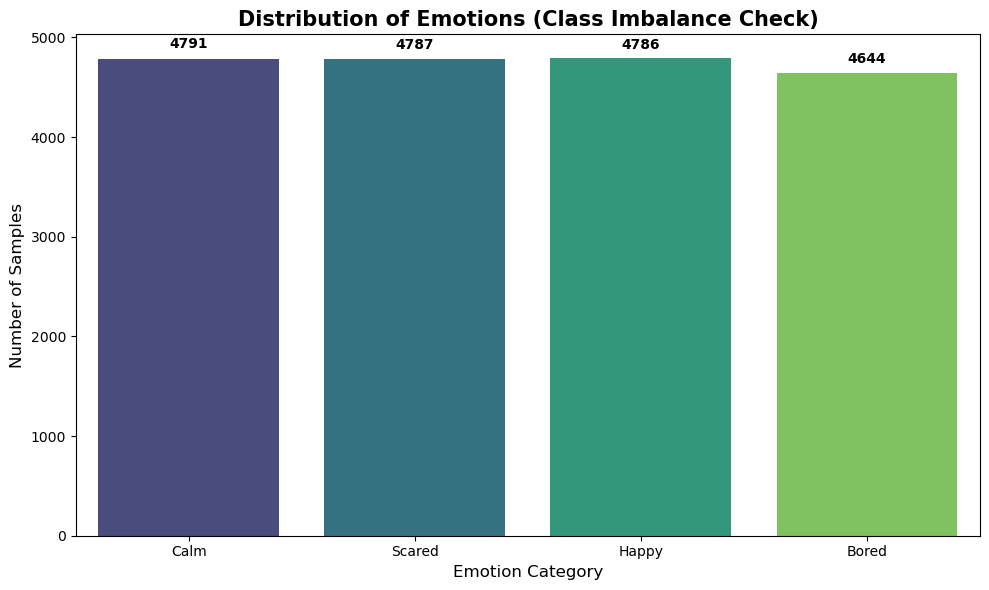

In [47]:
plt.figure(figsize=(10, 6))

sns.countplot(
    x='Classification', 
    data=csvfile, 
    hue='Classification', 
    palette='viridis', 
    legend=False
)

# Title and labels
plt.title('Distribution of Emotions (Class Imbalance Check)', fontsize=15, fontweight='bold')
plt.xlabel('Emotion Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

# Counts on top of the bars
counts = csvfile['Classification'].value_counts()

for i, label in enumerate(counts.index):
    count = counts[label]
    plt.text(i, count + 100, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Emotions are evenly distributed

### 2.2.3 Skew

Using skew, plotting histogram and density plot to find out skewness to determine which scaler to use

***Skew***

In [48]:
numerical_data.skew()

RAW_TP9    -0.596052
RAW_AF7     0.459461
RAW_AF8    -0.204828
RAW_TP10   -0.420771
dtype: float64

***Histogram for Numerical Features***

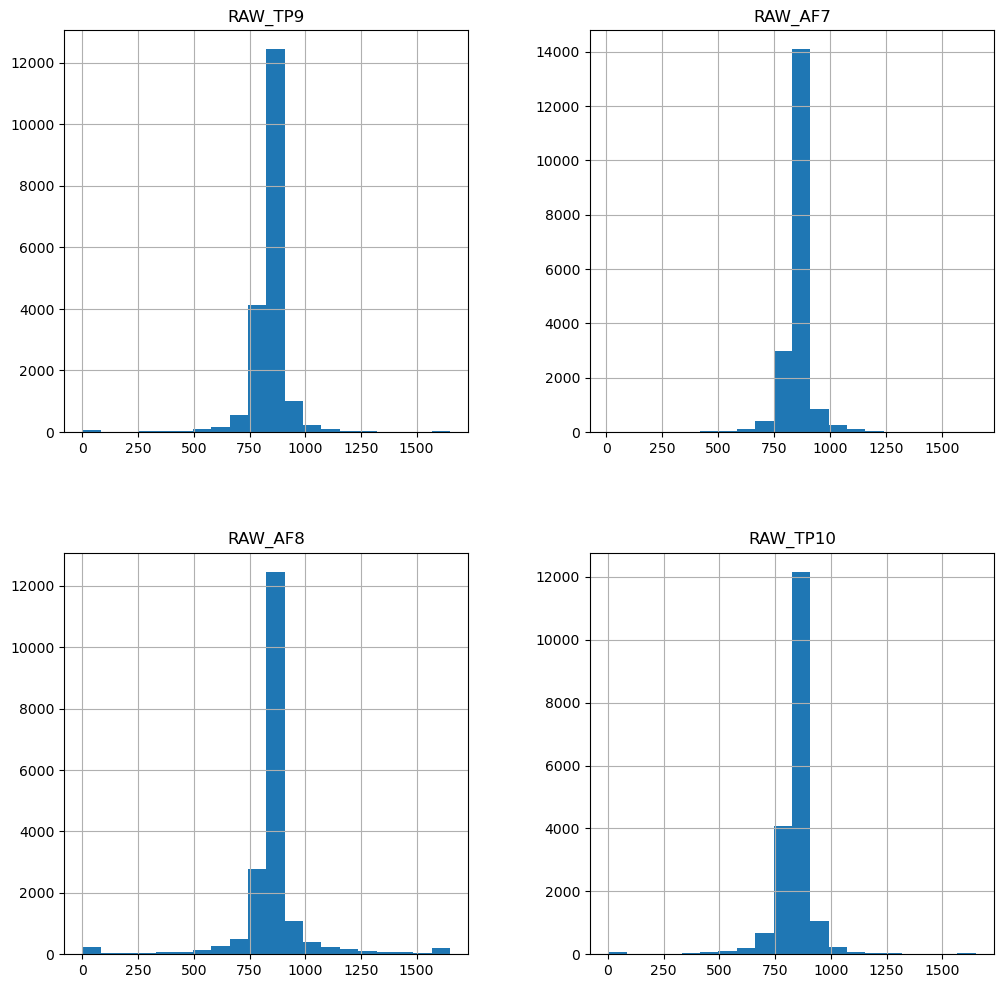

In [49]:
numerical_data.hist(figsize=(12,12),bins=20)
plt.show()

***Density Plot for Numerical Features***

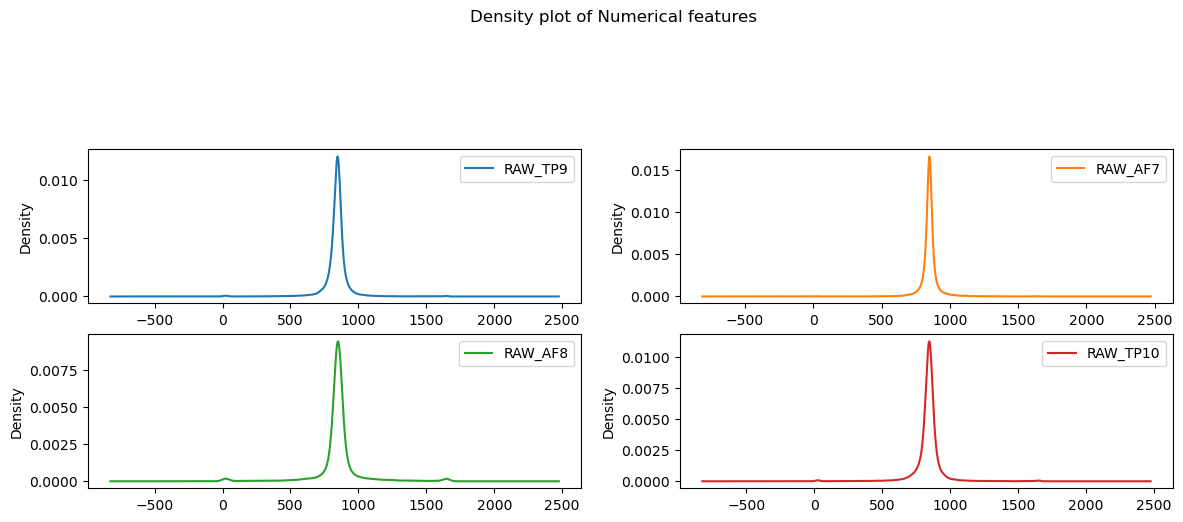

In [50]:
numerical_data.plot(kind='density',figsize=(14,14),subplots=True,layout=(6,2),title="Density plot of Numerical features",sharex=False)
plt.show()

***Verdict***

We should use Robust Scaler

## 2.3 Feature Correlation

***Correlation Matrix***

In [51]:
correlation_matrix = numerical_data.corr()
correlation_matrix

,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
RAW_TP9,1.000000,0.118822,0.011489,0.480414
RAW_AF7,0.118822,1.000000,0.122940,0.095268
RAW_AF8,0.011489,0.122940,1.000000,0.001759
RAW_TP10,0.480414,0.095268,0.001759,1.000000


***Heatmap for Correlation Matrix***

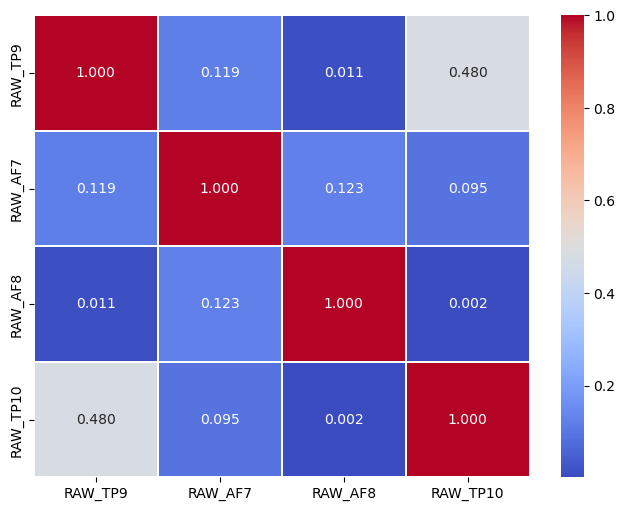

In [52]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.3)
plt.show()

No linear relationship between the EEG Signals

# **3. Modeling & Feature Extraction**

## 3.1 Label encoding + feature/target definition

### 3.1.1 Label Encoding
Label Encoding the Classification and Participant column to numbers

In [53]:
# Create stable numeric IDs for modeling, while keeping original labels intact

# (Helps reporting, confusion matrices, and the recommendation mapping.)



csvfile = csvfile.copy()



cls_codes, cls_uniques = pd.factorize(csvfile['Classification'])

csvfile['Classification_id'] = cls_codes.astype(int)



pid_codes, pid_uniques = pd.factorize(csvfile['Participant'])

csvfile['Participant_id'] = pid_codes.astype(int)



# Mappings for later interpretation

id_to_emotion = {int(i): str(lbl) for i, lbl in enumerate(cls_uniques)}

emotion_to_id = {str(lbl): int(i) for i, lbl in enumerate(cls_uniques)}



id_to_participant = {int(i): str(lbl) for i, lbl in enumerate(pid_uniques)}

participant_to_id = {str(lbl): int(i) for i, lbl in enumerate(pid_uniques)}



print('Emotion label mapping:', id_to_emotion)

print('Participants:', len(id_to_participant))


Emotion label mapping: {0: 'Calm', 1: 'Scared', 2: 'Happy', 3: 'Bored'}
Participants: 31


In [54]:
csvfile

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10,Classification_id,Participant_id
0,p1,Calm,848.16850,838.49817,861.86810,865.49450,0,0
1,p1,Calm,840.51280,851.79486,847.36260,844.94507,0,0
2,p1,Calm,819.96340,823.18680,815.53110,833.26010,0,0
3,p1,Calm,838.09520,842.12450,848.97437,850.58606,0,0
4,p1,Calm,849.78020,849.78020,829.63370,838.49817,0,0
...,...,...,...,...,...,...,...,...
19003,p9,Bored,865.89746,836.48350,858.24176,877.17950,3,30
19004,p9,Bored,874.76190,857.43590,831.24540,896.92310,3,30
19005,p9,Bored,906.99634,897.72894,925.53110,939.63370,3,30
19006,p9,Bored,795.38464,823.99270,979.12085,731.72160,3,30


### 3.1.2 Input and Output Split
Making the EEG Signals Input and Participant and Column be the Output

In [55]:
# X = Input features, y = Output label (numeric)

# Keep Participant_id separately (can be used later for group splits / analysis)



exclude_cols = {'Classification', 'Participant', 'Classification_id', 'Participant_id'}

feature_cols = [c for c in csvfile.columns if c not in exclude_cols]



x = csvfile[feature_cols]

y = csvfile['Classification_id']



print('Feature columns used for ML:', feature_cols)

print('x shape:', x.shape, 'y shape:', y.shape)


Feature columns used for ML: ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']
x shape: (19008, 4) y shape: (19008,)


## 3.2 Windowing + FFT Bandpower Features

This section creates window-level features from raw EEG channels (TP9, AF7, AF8, TP10) using the **P2 baseline workflow**:

- **Window first, split later**: we generate windows within each Participant×Class segment, then do a stratified train/test split on the resulting window-level samples.
- **Cleaning before extraction**: we coerce EEG columns to numeric and drop invalid rows before feature extraction.
- **Sliding windows**: window length `win=64` samples, step `step=16` samples (overlap).
- **FFT-only features**: compute per-window **bandpower** using FFT (no Welch/PSD, no time-domain stats).
- **Output features**: 4 channels × 5 bands = **20 FFT bandpower features** per window (log-transformed).

**Note (for P2 panel):** this baseline split is *not participant-disjoint*. Participant-disjoint validation (e.g., leave-one-participant-out) and other advanced formulations are planned for the final defense stage.

### 3.2.1 Windowed EEG Feature Extraction

In [56]:
eeg_cols = ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']

fs_hz = 256  # Sampling rate (Hz) used for FFT frequency axis

window_samples = 64   # Multiple windows per segment (~154 rows each)
step_samples = 16
win = int(window_samples)
step = int(step_samples)

bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta' : (13, 30),
    'gamma': (30, 45),
}

# Column names for classical ML features (4 channels × 5 bands)
feature_cols = [f"{ch}_{b}" for ch in eeg_cols for b in bands.keys()]


def bandpower_fft(x_1d: np.ndarray, fs: int, fmin: float, fmax: float) -> float:
    """Bandpower computed from FFT only (no Welch/PSD).

    Uses a Hann window and integrates periodogram power within [fmin, fmax).
    """
    x = np.asarray(x_1d, dtype=np.float64)
    n = int(x.shape[0])
    if n < 16:
        return 0.0

    # Remove DC offset and window to reduce leakage
    x = x - np.mean(x)
    w = np.hanning(n)
    xw = x * w

    # One-sided FFT
    X = np.fft.rfft(xw)
    freqs = np.fft.rfftfreq(n, d=1.0 / float(fs))

    # Periodogram-like power; absolute scaling not critical since we log-transform
    ps = (np.abs(X) ** 2) / (np.sum(w ** 2) + 1e-12)

    mask = (freqs >= float(fmin)) & (freqs < float(fmax))
    if not np.any(mask):
        return 0.0

    return float(np.trapz(ps[mask], freqs[mask]))


# -----------------------------------------------------------------------------
# P2 baseline workflow:
# 1) Clean the full dataset (no learned parameters).
# 2) Windowing + feature extraction across all data.
# 3) Train/test split on window-level samples (stratified by class).
# 4) Any scaling/normalization is fit on train only in later cells.
# -----------------------------------------------------------------------------

required_cols = set(['Participant_id', 'Classification_id', *eeg_cols])
missing = required_cols.difference(csvfile.columns)
if missing:
    raise ValueError(f"Missing required columns: {sorted(missing)}")


def clean_for_extraction(df: pd.DataFrame) -> pd.DataFrame:
    """Enhanced cleaning with ASR.

    Note: meegkit's ASR commonly expects data shaped as (n_channels, n_samples).
    This wrapper tries both orientations to be robust to version/API differences.
    """
    out = df.copy()

    # 1) Basic cleaning
    out = out.replace('#NUM!', np.nan)
    for c in eeg_cols:
        out[c] = pd.to_numeric(out[c], errors='coerce')

    out = out.dropna(subset=eeg_cols + ['Participant_id', 'Classification_id']).reset_index(drop=True)
    out['Participant_id'] = out['Participant_id'].astype(int)
    out['Classification_id'] = out['Classification_id'].astype(int)

    # 2) ASR Artifact Removal
    raw_data = out[eeg_cols].to_numpy(dtype=np.float64)  # (n_samples, n_channels)

    if raw_data.shape[0] < 2 * fs_hz:
        raise RuntimeError(
            f"Not enough samples for ASR: n_samples={raw_data.shape[0]}, expected >= {2 * fs_hz}"
        )

    if not np.isfinite(raw_data).all():
        raise RuntimeError("Non-finite values present after basic cleaning; ASR aborted")

    ASR_cls = ensure_asr()

    def _make_asr():
        # Try a few constructor signatures across meegkit versions.
        try:
            return ASR_cls(sfreq=fs_hz, cutoff=20, win_len=0.5)
        except TypeError:
            pass
        try:
            return ASR_cls(sfreq=fs_hz, cutoff=20)
        except TypeError:
            pass
        try:
            return ASR_cls(fs_hz, cutoff=20, win_len=0.5)
        except TypeError:
            pass
        return ASR_cls(fs_hz)

    err1 = None

    # Attempt 1: (n_channels, n_samples)
    data_for_asr = raw_data.T
    try:
        asr = _make_asr()
        asr.fit(data_for_asr)
        cleaned_for_asr = asr.transform(data_for_asr)
        cleaned = cleaned_for_asr.T
    except Exception as e:
        err1 = e
        cleaned = None

    # Attempt 2: (n_samples, n_channels)
    if cleaned is None:
        try:
            asr = _make_asr()
            asr.fit(raw_data)
            cleaned = asr.transform(raw_data)
        except Exception as e2:
            raise RuntimeError(
                "ASR failed with both orientations. "
                f"Error(ch×samples)={err1}; Error(samples×ch)={e2}"
            )

    if cleaned.shape != raw_data.shape:
        raise RuntimeError(f"ASR returned unexpected shape: cleaned={cleaned.shape}, expected={raw_data.shape}")

    out.loc[:, eeg_cols] = cleaned.astype(np.float32)

    print(f"ASR applied: input={raw_data.shape} (samples, ch)")

    return out


clean_df = clean_for_extraction(csvfile)

# Convenience alias if later cells want the ASR-cleaned dataframe explicitly
csvfile_asr = clean_df

print('After cleaning for extraction:', clean_df.shape)
print('Using win=', win, 'step=', step)


def build_windowed_features(df: pd.DataFrame):
    feature_rows = []
    y = []
    groups = []
    seq_windows = []

    group_cols = ['Participant_id', 'Classification_id']

    seg_lengths = [len(g) for _, g in df.groupby(group_cols, sort=False)]
    if len(seg_lengths) > 0:
        print('Segment length summary (rows per Participant×Class):')
        print(pd.Series(seg_lengths).describe())

    for (pid, class_id), g in df.groupby(group_cols, sort=False):
        eeg = g[eeg_cols].to_numpy(dtype=np.float32)
        n = eeg.shape[0]
        if n < win:
            continue

        for start in range(0, n - win + 1, step):
            seg = eeg[start:start + win]  # (win, 4)
            if not np.isfinite(seg).all():
                continue

            # Sequence window (for sequence models)
            seq_windows.append(seg)

            # FFT bandpower features (for classical models)
            feats = []
            for ch in range(seg.shape[1]):
                xch = seg[:, ch]
                for (fmin, fmax) in bands.values():
                    bp = bandpower_fft(xch, fs=fs_hz, fmin=fmin, fmax=fmax)
                    feats.append(np.log10(bp + 1e-8))

            feature_rows.append(feats)
            y.append(int(class_id))
            groups.append(int(pid))

    x_band = np.asarray(feature_rows, dtype=np.float32)
    X_seq = np.asarray(seq_windows, dtype=np.float32)
    y = np.asarray(y, dtype=np.int32)
    groups = np.asarray(groups, dtype=np.int32)
    return x_band, X_seq, y, groups


x_band_all, X_seq_all, y_all, groups_all = build_windowed_features(clean_df)

print('All windows:', 'x_band:', x_band_all.shape, 'X_seq:', X_seq_all.shape, 'y:', y_all.shape)

if y_all.size == 0:
    raise ValueError('No windows were generated. Check win/step and input data integrity.')

# Split windows into train/test
TEST_SIZE = float(globals().get('TEST_SIZE', 0.30))
RANDOM_STATE = int(globals().get('RANDOM_STATE', 5))
SPLIT_STRATEGY = str(globals().get('SPLIT_STRATEGY', 'random')).lower()

if SPLIT_STRATEGY == 'group':
    # Participant-disjoint split (more strict) — optional for later experiments
    from sklearn.model_selection import GroupShuffleSplit

    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss.split(x_band_all, y_all, groups=groups_all))

    x_band_train, x_band_test = x_band_all[train_idx], x_band_all[test_idx]
    X_train_seq, X_test_seq = X_seq_all[train_idx], X_seq_all[test_idx]
    y_train_arr, y_test_arr = y_all[train_idx], y_all[test_idx]
    groups_train, groups_test = groups_all[train_idx], groups_all[test_idx]

    print('Split strategy: group (participant-disjoint)')
else:
    x_band_train, x_band_test, X_train_seq, X_test_seq, y_train_arr, y_test_arr, groups_train, groups_test = train_test_split(
        x_band_all,
        X_seq_all,
        y_all,
        groups_all,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y_all,
    )
    print('Split strategy: random (stratified by class)')

print('Train shapes:', 'x_band_train:', x_band_train.shape, 'X_train_seq:', X_train_seq.shape, 'y_train:', y_train_arr.shape)
print('Test  shapes:', 'x_band_test :', x_band_test.shape, 'X_test_seq :', X_test_seq.shape, 'y_test :', y_test_arr.shape)
print('Feature columns used for FFT features:', feature_cols)

ASR applied: input=(18988, 4) (samples, ch)
After cleaning for extraction: (18988, 8)
Using win= 64 step= 16
Segment length summary (rows per Participant×Class):
count    124.000000
mean     153.129032
std        3.861353
min      125.000000
25%      154.000000
50%      154.000000
75%      155.000000
max      158.000000
dtype: float64
All windows: x_band: (740, 20) X_seq: (740, 64, 4) y: (740,)
Split strategy: random (stratified by class)
Train shapes: x_band_train: (518, 20) X_train_seq: (518, 64, 4) y_train: (518,)
Test  shapes: x_band_test : (222, 20) X_test_seq : (222, 64, 4) y_test : (222,)
Feature columns used for FFT features: ['RAW_TP9_delta', 'RAW_TP9_theta', 'RAW_TP9_alpha', 'RAW_TP9_beta', 'RAW_TP9_gamma', 'RAW_AF7_delta', 'RAW_AF7_theta', 'RAW_AF7_alpha', 'RAW_AF7_beta', 'RAW_AF7_gamma', 'RAW_AF8_delta', 'RAW_AF8_theta', 'RAW_AF8_alpha', 'RAW_AF8_beta', 'RAW_AF8_gamma', 'RAW_TP10_delta', 'RAW_TP10_theta', 'RAW_TP10_alpha', 'RAW_TP10_beta', 'RAW_TP10_gamma']


In [57]:
# FFT-only tabular features (no extra feature engineering, no time-domain stats)

if 'x_band_train' not in globals() or 'x_band_test' not in globals():
    raise NameError('Expected x_band_train/x_band_test from the windowing cell')
if 'y_train_arr' not in globals() or 'y_test_arr' not in globals():
    raise NameError('Expected y_train_arr/y_test_arr from the windowing cell')

# Reconstruct feature column names if needed
_eeg_cols = globals().get('eeg_cols', ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10'])
_bands = globals().get('bands', {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta' : (13, 30),
    'gamma': (30, 45),
})

feature_cols = globals().get('feature_cols', [f"{ch}_{b}" for ch in _eeg_cols for b in _bands.keys()])

x_band_train_np = np.asarray(x_band_train)
x_band_test_np = np.asarray(x_band_test)

# If something got out of sync, fall back to generic feature names
if len(feature_cols) != x_band_train_np.shape[1]:
    feature_cols = [f"feat_{i}" for i in range(x_band_train_np.shape[1])]

X_train = pd.DataFrame(x_band_train_np, columns=feature_cols).reset_index(drop=True)
X_test = pd.DataFrame(x_band_test_np, columns=feature_cols).reset_index(drop=True)

y_train = pd.Series(y_train_arr)
y_test = pd.Series(y_test_arr)

print('FFT TRAIN features:', X_train.shape, 'y_train:', y_train.shape)
print('FFT TEST  features:', X_test.shape, 'y_test :', y_test.shape)

# Optional: combined feature frame for quick EDA plots
x_band = pd.concat([X_train, X_test], ignore_index=True)

FFT TRAIN features: (518, 20) y_train: (518,)
FFT TEST  features: (222, 20) y_test : (222,)


# **4. Scaling (Train-only)**



The train/test split is applied at the **window level** in the previous cell.

Here we only scale the engineered tabular features using a scaler **fit on training windows only**, then apply it to the test windows.


In [58]:
# Scaling (fit on train only)

##

# Downstream classical ML cells expect X_train_scaled / X_test_scaled.



scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)



print('Scaled:', X_train_scaled.shape, X_test_scaled.shape)


Scaled: (518, 20) (222, 20)


`X_train`: FFT bandpower features per window. Shape like `(n_windows, 20)` (4 channels × 5 bands).

<br>

`X_train_scaled`: the same features, but scaled using the scaler fit on the training windows only (correct for Logistic Regression / SVM / KNN / MLP).

<br>

`X_train_seq`: raw EEG window sequences (time series). Shape like `(n_windows, timesteps, 4)`. This is for sequence models (CNN/RNN/EEGNet/Transformer).

Tip: set `TEST_SIZE`, `RANDOM_STATE`, and `SPLIT_STRATEGY` (`"random"` or `"group"`) at the top of the notebook if you want to reproduce different splits.

# **5. Classical ML Models (Tabular Features)**

Baselines trained on engineered window features (after scaling).

## 5.1 ROC and AUC

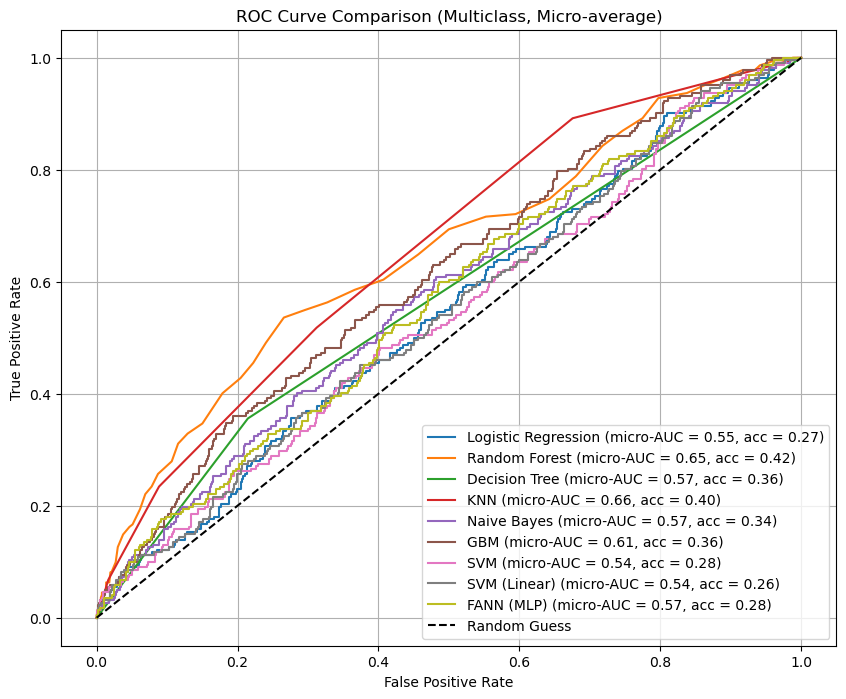

Classical model accuracies:
- Random Forest: 0.4189
- KNN: 0.3964
- GBM: 0.3604
- Decision Tree: 0.3559
- Naive Bayes: 0.3423
- SVM: 0.2793
- FANN (MLP): 0.2793
- Logistic Regression: 0.2658
- SVM (Linear): 0.2613


In [59]:
models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        max_iter=5000,
        solver='lbfgs',
    ),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=5),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "GBM": GradientBoostingClassifier(random_state=5),
    "SVM": SVC(kernel='linear', class_weight='balanced', random_state=5),
    "SVM (Linear)": LinearSVC(
        class_weight='balanced',
        random_state=5,
        max_iter=10000,
        dual=False,
    ),
    "FANN (MLP)": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=300,
        early_stopping=True,
        random_state=5,
    ),
}

# Backwards-compatible outputs used later in the notebook
classic_acc = {}
classic_models = {}

def get_score_matrix(fitted_model, X):
    # Prefer probabilities when available; fall back to decision_function (e.g., LinearSVC)
    if hasattr(fitted_model, "predict_proba"):
        scores = fitted_model.predict_proba(X)
    elif hasattr(fitted_model, "decision_function"):
        scores = fitted_model.decision_function(X)
    else:
        raise ValueError(f"Model {type(fitted_model).__name__} has neither predict_proba nor decision_function")

    scores = np.asarray(scores)
    if scores.ndim == 1:
        # Binary case: convert (n_samples,) -> (n_samples, 1) for consistent ravel() behavior
        scores = scores.reshape(-1, 1)
    return scores

plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    classic_models[name] = model

    # Accuracy + predictions (used later for reports)
    y_pred = model.predict(X_test_scaled)
    classic_acc[name] = accuracy_score(y_test, y_pred)

    # Create legacy variable names expected later in the notebook
    if name == "Logistic Regression":
        logistic_model = model
        y_prediction = y_pred
        log_acc = classic_acc[name]
    elif name == "Decision Tree":
        dt_model = model
        y_pred_dt = y_pred
        dt_acc = classic_acc[name]
    elif name == "Random Forest":
        rf_model = model
        y_pred_rf = y_pred
        rf_acc = classic_acc[name]
    elif name == "KNN":
        knn_model = model
        y_pred_knn = y_pred
        knn_acc = classic_acc[name]
    elif name == "Naive Bayes":
        nb_model = model
        y_pred_nb = y_pred
        nb_acc = classic_acc[name]
    elif name == "GBM":
        gbm_model = model
        y_pred_gbm = y_pred
        gbm_acc = classic_acc[name]
    elif name == "FANN (MLP)":
        fann_model = model
        y_pred_fann = y_pred
        fann_acc = classic_acc[name]
    elif name == "SVM":
        svm_model = model
        y_pred_svm = y_pred
        svm_svc_acc = classic_acc[name]
    elif name == "SVM (Linear)":
        svm_linear_model = model
        y_pred_svm_linear = y_pred
        svm_linear_acc = classic_acc[name]
        # historically `svm_acc` is used for the linear variant
        svm_acc = svm_linear_acc

    # ROC scores
    y_score = get_score_matrix(model, X_test_scaled)  # (n_samples, n_classes) or (n_samples, 1)

    # Binarize y_test using the model's class order to align columns
    y_test_bin = label_binarize(y_test, classes=model.classes_)

    # Micro-average ROC (treat each class prediction as a binary decision)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (micro-AUC = {roc_auc:.2f}, acc = {classic_acc[name]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Multiclass, Micro-average)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Quick accuracy summary
print('Classical model accuracies:')
for name, acc_ in sorted(classic_acc.items(), key=lambda kv: kv[1], reverse=True):
    print(f"- {name}: {acc_:.4f}")

## 5.10 Neural Networks
Using X_train_scaled / X_test_scaled

In [60]:
## Build one-hot targets
y_train_np = np.asarray(y_train, dtype=np.int32)
y_test_np = np.asarray(y_test, dtype=np.int32)

# Use the global label schema (no need to peek at y_test distribution)
if 'Classification_id' in csvfile.columns:
    num_classes = int(csvfile['Classification_id'].nunique())
else:
    num_classes = int(np.max(y_train_np) + 1)
print('num_classes =', num_classes)

y_train_cat = tf.keras.utils.to_categorical(y_train_np, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test_np, num_classes=num_classes)

# Participant-disjoint validation split (avoid overlapping-window leakage across val/train)
X_nn_train = X_train_scaled
y_nn_train = y_train_cat
X_nn_val = None
y_nn_val = None

if 'groups_train' in globals():
    groups_train_nn = np.asarray(groups_train)
    if len(groups_train_nn) == X_train_scaled.shape[0]:
        unique_pids = np.unique(groups_train_nn)
        if unique_pids.size >= 2:
            VAL_PARTICIPANT = int(globals().get('VAL_PARTICIPANT', -1))
            if VAL_PARTICIPANT in unique_pids:
                val_pid = int(VAL_PARTICIPANT)
            else:
                VAL_FOLD = int(globals().get('VAL_FOLD', 0))
                val_pid = int(unique_pids[VAL_FOLD % unique_pids.size])
            val_mask = (groups_train_nn == val_pid)
            if val_mask.any() and (~val_mask).any():
                X_nn_train = X_train_scaled[~val_mask]
                y_nn_train = y_train_cat[~val_mask]
                X_nn_val = X_train_scaled[val_mask]
                y_nn_val = y_train_cat[val_mask]
                print(
                    f"Dense NN validation: val Participant_id={val_pid} "
                    f"(val windows={val_mask.sum()}, train windows={(~val_mask).sum()})"
                )

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(num_classes, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

fit_kwargs = dict(
    x=X_nn_train,
    y=y_nn_train,
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1,
 )
if X_nn_val is not None:
    fit_kwargs['validation_data'] = (X_nn_val, y_nn_val)
else:
    # Fallback if groups_train isn't available (still train-only)
    fit_kwargs['validation_split'] = 0.15

history = model.fit(**fit_kwargs)

loss, nn_acc = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Dense NN (regularized) Accuracy = {nn_acc:.4f}")

num_classes = 4
Dense NN validation: val Participant_id=0 (val windows=16, train windows=502)


I0000 00:00:1769889215.332234   77570 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5762 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/150


2026-02-01 01:53:38.061859: I external/local_xla/xla/service/service.cc:163] XLA service 0x79f974004d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-01 01:53:38.061878: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2026-02-01 01:53:38.126130: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-01 01:53:38.392752: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800


 1/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.2812 - loss: 2.8297

I0000 00:00:1769889219.942909   78833 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.2570 - loss: 3.2023 - val_accuracy: 0.2500 - val_loss: 2.0633
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2669 - loss: 2.9814 - val_accuracy: 0.3125 - val_loss: 2.0611
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2610 - loss: 3.1457 - val_accuracy: 0.3125 - val_loss: 2.0615
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2490 - loss: 3.0268 - val_accuracy: 0.1875 - val_loss: 2.0614
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2430 - loss: 3.0510 - val_accuracy: 0.1875 - val_loss: 2.0618
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2669 - loss: 2.9921 - val_accuracy: 0.1875 - val_loss: 2.0612
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2371 - loss: 2.9780 - val_accuracy: 0.2500 - val_loss: 2.0615
Epoch 8/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2450 - loss: 2.9345 - val_accuracy: 0.2500 - val_loss: 2

# **6. Deep Learning Models (Raw Windows)**

Sequence/conv models trained on raw window tensors with per-channel normalization (fit on train only).

## 6.1 Setup
- Converts `X_train_seq`/`X_test_seq` to `float32` and reads `timesteps` + `n_channels`. <br>
- Normalizes the sequences per channel using mean/std computed on the training windows only (to avoid leakage). <br>
- Converts `y_train`/`y_test` to NumPy ints and sets `num_classes`. <br>
- Computes class weights from the training labels for imbalance. <br>
- Defines early stopping and a helper function `train_eval_keras(...)` that compiles, trains, and evaluates a Keras model on `X_train_seq`. <br>


In [61]:
# Correct shape: (n_windows, timesteps, n_channels=4)

X_train_seq = np.asarray(X_train_seq, dtype=np.float32)
X_test_seq = np.asarray(X_test_seq, dtype=np.float32)
timesteps = int(X_train_seq.shape[1])
n_channels = int(X_train_seq.shape[2])
print('Sequence tensor shape:', X_train_seq.shape, '(timesteps=', timesteps, ', channels=', n_channels, ')')

# -------------------------------
# Participant-disjoint val split
# -------------------------------
X_val_seq = None
y_val_np = None
if 'groups_train' in globals():
    groups_train_seq = np.asarray(groups_train, dtype=np.int32)
    if len(groups_train_seq) == X_train_seq.shape[0]:
        unique_pids = np.unique(groups_train_seq)
        if unique_pids.size >= 2:
            VAL_PARTICIPANT = int(globals().get('VAL_PARTICIPANT', -1))
            if VAL_PARTICIPANT in unique_pids:
                val_pid = int(VAL_PARTICIPANT)
            else:
                VAL_FOLD = int(globals().get('VAL_FOLD', 29))
                val_pid = int(unique_pids[VAL_FOLD % unique_pids.size])
            val_mask = (groups_train_seq == val_pid)
            if val_mask.any() and (~val_mask).any():
                X_val_seq = X_train_seq[val_mask].copy()
                X_train_seq = X_train_seq[~val_mask].copy()
                y_val_np = np.asarray(y_train, dtype=np.int32)[val_mask].copy()
                print(
                    f"Deep learning validation: val Participant_id={val_pid} "
                    f"(val windows={val_mask.sum()}, train windows={(~val_mask).sum()})"
                )

# Normalize per-channel using TRAINING statistics only (prevents leakage into val/test)
seq_mean = X_train_seq.mean(axis=(0, 1), keepdims=True)
seq_std = X_train_seq.std(axis=(0, 1), keepdims=True) + 1e-6
X_train_seq = (X_train_seq - seq_mean) / seq_std
X_test_seq = (X_test_seq - seq_mean) / seq_std
if X_val_seq is not None:
    X_val_seq = (X_val_seq - seq_mean) / seq_std

y_train_np = np.asarray(y_train, dtype=np.int32)
if X_val_seq is not None:
    # keep y_train_np aligned with X_train_seq after removing the val participant
    y_train_np = y_train_np[~val_mask]
y_test_np = np.asarray(y_test, dtype=np.int32)

# Number of classes from the fixed label schema (robust if a class is absent in the current training split)
if 'Classification_id' in csvfile.columns:
    num_classes = int(csvfile['Classification_id'].nunique())
else:
    num_classes = int(np.max(y_train_np) + 1)
print('num_classes =', num_classes)

# Class weights to mitigate imbalance (train labels only)
class_weights = None
classes = np.arange(num_classes, dtype=np.int32)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
print('class_weights:', class_weights)

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

def train_eval_keras(model, name: str, epochs: int = 60, batch_size: int = 64):
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
    )
    fit_kwargs = dict(
        x=X_train_seq,
        y=y_train_np,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        class_weight=class_weights,
        verbose=0,
    )
    if X_val_seq is not None and y_val_np is not None:
        fit_kwargs['validation_data'] = (X_val_seq, y_val_np)
    else:
        # Fallback if groups_train isn't available (still train-only)
        fit_kwargs['validation_split'] = 0.1

    model.fit(**fit_kwargs)
    loss, acc = model.evaluate(X_test_seq, y_test_np, verbose=0)
    print(f"{name} Accuracy = {acc:.4f}")
    return acc

Sequence tensor shape: (518, 64, 4) (timesteps= 64 , channels= 4 )
Deep learning validation: val Participant_id=0 (val windows=16, train windows=502)
num_classes = 4
class_weights: {0: 0.9881889763779528, 1: 0.98046875, 2: 1.004, 3: 1.028688524590164}


## 6.2 DeepConvNet

In [62]:
# Convert to 2D conv format: (batch, channels, samples, 1)
X_train_eeg = np.transpose(X_train_seq, (0, 2, 1))[:, :, :, None]
X_test_eeg = np.transpose(X_test_seq, (0, 2, 1))[:, :, :, None]
X_val_eeg = None
if 'X_val_seq' in globals() and X_val_seq is not None:
    X_val_eeg = np.transpose(X_val_seq, (0, 2, 1))[:, :, :, None]

n_channels = int(X_train_eeg.shape[1])
timesteps = int(X_train_eeg.shape[2])
num_classes = int(np.unique(y_train_np).size) if 'y_train_np' in globals() else int(csvfile['Classification_id'].nunique())

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

kernel_w = max(5, min(15, timesteps))
pool_w = 2 if timesteps >= 2 else 1

deepconvnet_model = Sequential([
    Input(shape=(n_channels, timesteps, 1)),
    Conv2D(25, (1, kernel_w), padding='same', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    # Mix information across channels
    Conv2D(25, (n_channels, 1), padding='valid', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    AveragePooling2D((1, pool_w)),
    Dropout(0.5),

    Conv2D(50, (1, kernel_w), padding='same', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    AveragePooling2D((1, pool_w)),
    Dropout(0.5),

    Flatten(),
    Dense(num_classes, activation='softmax'),
])

deepconvnet_model.compile(optimizer=Adam(1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

fit_kwargs = dict(
    x=X_train_eeg,
    y=y_train_np,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0,
    class_weight=class_weights if 'class_weights' in globals() else None,
 )
if X_val_eeg is not None and 'y_val_np' in globals() and y_val_np is not None:
    fit_kwargs['validation_data'] = (X_val_eeg, y_val_np)
else:
    fit_kwargs['validation_split'] = 0.1

deepconvnet_model.fit(**fit_kwargs)
_, deepconvnet_acc = deepconvnet_model.evaluate(X_test_eeg, y_test_np, verbose=0)
print(f"DeepConvNet Accuracy = {deepconvnet_acc:.4f}")

DeepConvNet Accuracy = 0.2703


## 6.3 EEGNet

In [63]:
# Convert to 2D conv format: (batch, channels, samples, 1) where channels=4, samples=timesteps
X_train_eeg = np.transpose(X_train_seq, (0, 2, 1))[:, :, :, None]
X_test_eeg = np.transpose(X_test_seq, (0, 2, 1))[:, :, :, None]
X_val_eeg = None
if 'X_val_seq' in globals() and X_val_seq is not None:
    X_val_eeg = np.transpose(X_val_seq, (0, 2, 1))[:, :, :, None]

n_channels = int(X_train_eeg.shape[1])
timesteps = int(X_train_eeg.shape[2])
num_classes = int(np.unique(y_train_np).size) if 'y_train_np' in globals() else int(csvfile['Classification_id'].nunique())

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

kern_len = max(8, min(64, timesteps))
F1 = 8
D = 2
F2 = F1 * D

inp = Input(shape=(n_channels, timesteps, 1))
x = Conv2D(F1, (1, kern_len), padding='same', use_bias=False)(inp)
x = BatchNormalization()(x)

# Spatial filtering across channels
x = DepthwiseConv2D((n_channels, 1), depth_multiplier=D, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = AveragePooling2D((1, max(1, timesteps // 8)))(x)
x = Dropout(0.25)(x)

x = SeparableConv2D(F2, (1, max(3, kern_len // 2)), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = AveragePooling2D((1, max(1, timesteps // 8)))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
out = Dense(num_classes, activation='softmax')(x)
eegnet_model = tf.keras.Model(inputs=inp, outputs=out)

eegnet_model.compile(optimizer=Adam(1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

fit_kwargs = dict(
    x=X_train_eeg,
    y=y_train_np,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0,
    class_weight=class_weights if 'class_weights' in globals() else None,
 )
if X_val_eeg is not None and 'y_val_np' in globals() and y_val_np is not None:
    fit_kwargs['validation_data'] = (X_val_eeg, y_val_np)
else:
    fit_kwargs['validation_split'] = 0.1

eegnet_model.fit(**fit_kwargs)
_, eegnet_acc = eegnet_model.evaluate(X_test_eeg, y_test_np, verbose=0)
print(f"EEGNet Accuracy = {eegnet_acc:.4f}")

EEGNet Accuracy = 0.2523


## 6.4 Mambular
Inspired gated causal Conv1D stack (Keras 3 compatible)

In [64]:
# "Mambular"-inspired gated causal Conv1D stack (Keras 3 compatible)

class GLU(Layer):
    def call(self, inputs):
        a, b = tf.split(inputs, num_or_size_splits=2, axis=-1)
        return a * tf.sigmoid(b)

def mambular_block(x, d_model: int, kernel_size: int = 7, dropout: float = 0.2):
    h = Conv1D(filters=2 * d_model, kernel_size=kernel_size, padding='causal')(x)
    h = GLU()(h)
    h = Dropout(dropout)(h)
    h = Dense(d_model)(h)
    return Add()([x, h])

d_model_m = 64
inp = Input(shape=(timesteps, n_channels))
x = Dense(d_model_m)(inp)
x = LayerNormalization()(x)
x = mambular_block(x, d_model_m, kernel_size=min(7, timesteps))
x = LayerNormalization()(x)
x = mambular_block(x, d_model_m, kernel_size=min(15, timesteps))
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
out = Dense(num_classes, activation='softmax')(x)
mambular_model = Model(inp, out)

mambular_acc = train_eval_keras(mambular_model, 'Mambular')

2026-02-01 01:54:09.534862: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 01:54:09.687162: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 01:54:10.025309: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 01:54:10.180974: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 01:54:13.719995: E external/local_xla/xla/stream_

Mambular Accuracy = 0.3559


## 6.5 Transformer
Transformer encoder over time (timesteps) with channel features

In [65]:
d_model = 64
num_heads = 4
ff_dim = 128

inp = Input(shape=(timesteps, n_channels))
x = Dense(d_model)(inp)

pos = tf.range(start=0, limit=timesteps, delta=1)
pos_emb = tf.keras.layers.Embedding(input_dim=timesteps, output_dim=d_model)(pos)
x = x + pos_emb
x = LayerNormalization()(x)

attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
x = Add()([x, attn_out])
x = LayerNormalization()(x)

ffn = Dense(ff_dim, activation='relu')(x)
ffn = Dropout(0.2)(ffn)
ffn = Dense(d_model)(ffn)
x = Add()([x, ffn])
x = LayerNormalization()(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax')(x)
transformer_model = tf.keras.Model(inputs=inp, outputs=out)
transformer_acc = train_eval_keras(transformer_model, 'Transformer')

Transformer Accuracy = 0.2748


## 6.6 LSTM - Long Short-Term Memory

In [66]:
# LSTM (correct: timesteps=time, features=channels)
lstm_model = Sequential([
    Input(shape=(timesteps, n_channels)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax'),
])
lstm_acc = train_eval_keras(lstm_model, 'LSTM')

LSTM Accuracy = 0.3063


## 6.7 RNN - Recurrent Neural Network

In [67]:
# RNN (SimpleRNN) — correct: timesteps=time, features=channels
rnn_model = Sequential([
    Input(shape=(timesteps, n_channels)),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax'),
])
rnn_acc = train_eval_keras(rnn_model, 'RNN')

RNN Accuracy = 0.2748


## 6.8 Hybrid: **CNN** + **BiLSTM** with **Self-Attention**

In [68]:
# Hybrid model: CNN + BiLSTM with Self-Attention

k1 = min(7, int(timesteps))
k2 = min(5, int(timesteps))
stride2 = 2 if int(timesteps) >= 2 else 1

inp = Input(shape=(int(timesteps), int(n_channels)))
x = Conv1D(64, kernel_size=k1, padding='same', activation='relu')(inp)
x = Dropout(0.2)(x)
x = Conv1D(64, kernel_size=k2, padding='same', activation='relu', strides=stride2)(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)

attn = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = Add()([x, attn])
x = LayerNormalization()(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
out = Dense(int(num_classes), activation='softmax')(x)

cnn_bilstm_attn_model = tf.keras.Model(inputs=inp, outputs=out)
cnn_bilstm_attn_acc = train_eval_keras(cnn_bilstm_attn_model, 'CNN-BiLSTM + Attention')

CNN-BiLSTM + Attention Accuracy = 0.2523


## 6.9 BERT

In [69]:
class CLSToken(Layer):
    def __init__(self, d_model: int, **kwargs):
        super().__init__(**kwargs)
        self.d_model = int(d_model)
        self.cls = None

    def build(self, input_shape):
        self.cls = self.add_weight(
            name='cls_token',
            shape=(1, 1, self.d_model),
            initializer='zeros',
            trainable=True,
        )
        super().build(input_shape)

    def call(self, x):
        batch = tf.shape(x)[0]
        cls_tokens = tf.tile(self.cls, [batch, 1, 1])
        return tf.concat([cls_tokens, x], axis=1)

def transformer_encoder(x, d_model: int, num_heads: int, ff_dim: int, dropout: float = 0.1):
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x, x)
    attn_out = Dropout(dropout)(attn_out)
    x = Add()([x, attn_out])
    x = LayerNormalization()(x)

    ffn = Dense(ff_dim, activation='relu')(x)
    ffn = Dropout(dropout)(ffn)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout)(ffn)
    x = Add()([x, ffn])
    x = LayerNormalization()(x)
    return x

# Hyperparams (kept small for speed)
bert_d_model = 64
bert_num_heads = 4
bert_ff_dim = 128
bert_num_layers = 2
bert_dropout = 0.15

inp = Input(shape=(int(timesteps), int(n_channels)))
x = Dense(bert_d_model)(inp)
x = CLSToken(bert_d_model)(x)

# Learnable positional embeddings for (CLS + timesteps) positions
pos_ids = tf.range(start=0, limit=int(timesteps) + 1, delta=1)
pos_emb = Embedding(input_dim=int(timesteps) + 1, output_dim=bert_d_model)(pos_ids)
x = x + pos_emb

x = Dropout(bert_dropout)(x)
for _ in range(bert_num_layers):
    x = transformer_encoder(x, d_model=bert_d_model, num_heads=bert_num_heads, ff_dim=bert_ff_dim, dropout=bert_dropout)

# CLS pooling
cls_vec = x[:, 0, :]
out = Dense(int(num_classes), activation='softmax')(cls_vec)
bert_model = Model(inp, out)

bert_acc = train_eval_keras(bert_model, 'BERT-style Transformer')

BERT-style Transformer Accuracy = 0.2432


In [70]:
# --- 1D CNN baseline (EEG sequence model) ---
from keras import Sequential
from keras.layers import (
    InputLayer, Conv1D, BatchNormalization, Activation, MaxPooling1D,
    GlobalAveragePooling1D, Dropout, Dense
 )
from keras.regularizers import l2

cnn_model = Sequential([
    InputLayer(input_shape=(int(timesteps), int(n_channels))),

    Conv1D(64, kernel_size=7, padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.20),

    Conv1D(128, kernel_size=5, padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.30),

    Conv1D(256, kernel_size=3, padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    GlobalAveragePooling1D(),
    Dropout(0.40),

    Dense(128, activation='relu'),
    Dropout(0.30),
    Dense(int(num_classes), activation='softmax')
])

cnn_acc = train_eval_keras(cnn_model, '1D CNN')

/home/rutab/.local/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1D CNN Accuracy = 0.2658


# **7. Results summary**

Determining the accuracies

## 7.1 Accuracies

In [71]:
# Print accuracies (only for models that were run)


def _p(label: str, var: str):
    if var in globals() and globals()[var] is not None:
        print(f"{label:<30} - {float(globals()[var])}")


print('Classic Model Accuracies:\n')
_p('Logistic Regression Accuracy', 'log_acc')
_p('Decision Tree Accuracy', 'dt_acc')
_p('KNN Accuracy', 'knn_acc')
_p('Naive Bayes Accuracy', 'nb_acc')
_p('GBM Accuracy', 'gbm_acc')
_p('SVM (Linear) Accuracy', 'svm_acc')
_p('FANN (MLP) Accuracy', 'fann_acc')
_p('Neural Network (Dense) Accuracy', 'nn_acc')


print('\nDeep Learning Models Accuracies:\n')
_p('RNN Accuracy', 'rnn_acc')
_p('LSTM Accuracy', 'lstm_acc')
_p('Transformer Accuracy', 'transformer_acc')
_p('Mambular Accuracy', 'mambular_acc')
_p('EEGNet Accuracy', 'eegnet_acc')
_p('DeepConvNet Accuracy', 'deepconvnet_acc')
_p('1D CNN Accuracy', 'cnn_acc')
_p('BERT-style Transformer Accuracy', 'bert_acc')
_p('CNN-BiLSTM + Attention Accuracy', 'cnn_bilstm_attn_acc')

Classic Model Accuracies:

Logistic Regression Accuracy   - 0.26576576576576577
Decision Tree Accuracy         - 0.35585585585585583
KNN Accuracy                   - 0.3963963963963964
Naive Bayes Accuracy           - 0.34234234234234234
GBM Accuracy                   - 0.36036036036036034
SVM (Linear) Accuracy          - 0.26126126126126126
FANN (MLP) Accuracy            - 0.27927927927927926
Neural Network (Dense) Accuracy - 0.22972972691059113

Deep Learning Models Accuracies:

RNN Accuracy                   - 0.2747747600078583
LSTM Accuracy                  - 0.30630630254745483
Transformer Accuracy           - 0.2747747600078583
Mambular Accuracy              - 0.3558558523654938
EEGNet Accuracy                - 0.2522522509098053
DeepConvNet Accuracy           - 0.2702702581882477
1D CNN Accuracy                - 0.2657657563686371
BERT-style Transformer Accuracy - 0.2432432472705841
CNN-BiLSTM + Attention Accuracy - 0.2522522509098053


## 7.2 Accuracy Comparison Chart

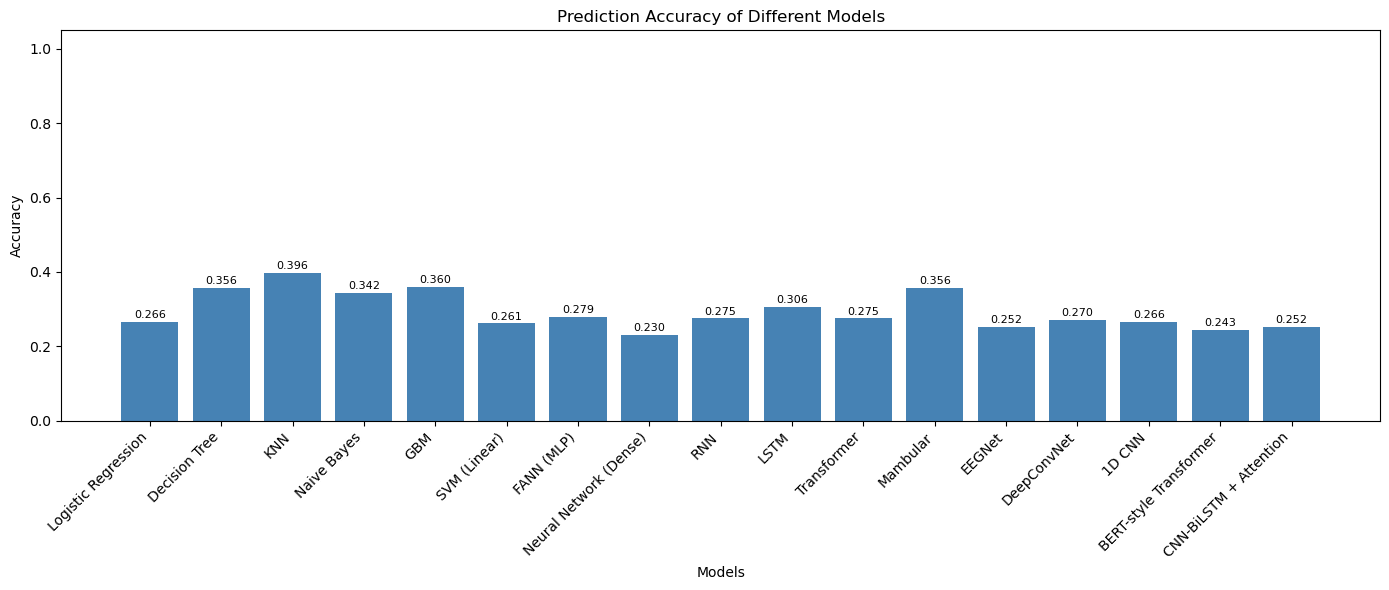

In [72]:
# Accuracy comparison across models (only include ones that exist)
model_acc = {}
for name, var in [
    ('Logistic Regression', 'log_acc'),
    ('Decision Tree', 'dt_acc'),
    ('KNN', 'knn_acc'),
    ('Naive Bayes', 'nb_acc'),
    ('GBM', 'gbm_acc'),
    ('SVM (Linear)', 'svm_acc'),
    ('FANN (MLP)', 'fann_acc'),
    ('Neural Network (Dense)', 'nn_acc'),
    ('RNN', 'rnn_acc'),
    ('LSTM', 'lstm_acc'),
    ('Transformer', 'transformer_acc'),
    ('Mambular', 'mambular_acc'),
    ('EEGNet', 'eegnet_acc'),
    ('DeepConvNet', 'deepconvnet_acc'),
    ('1D CNN', 'cnn_acc'),
    ('BERT-style Transformer', 'bert_acc'),
    ('CNN-BiLSTM + Attention', 'cnn_bilstm_attn_acc'),
 ]:
    if var in globals():
        model_acc[name] = float(globals()[var])

plt.figure(figsize=(14, 6))
names = list(model_acc.keys())
scores = list(model_acc.values())
bars = plt.bar(names, scores, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy of Different Models')

for b, s in zip(bars, scores):
    plt.text(b.get_x() + b.get_width()/2, s + 0.005, f'{s:.3f}', ha='center', va='bottom', fontsize=8)

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

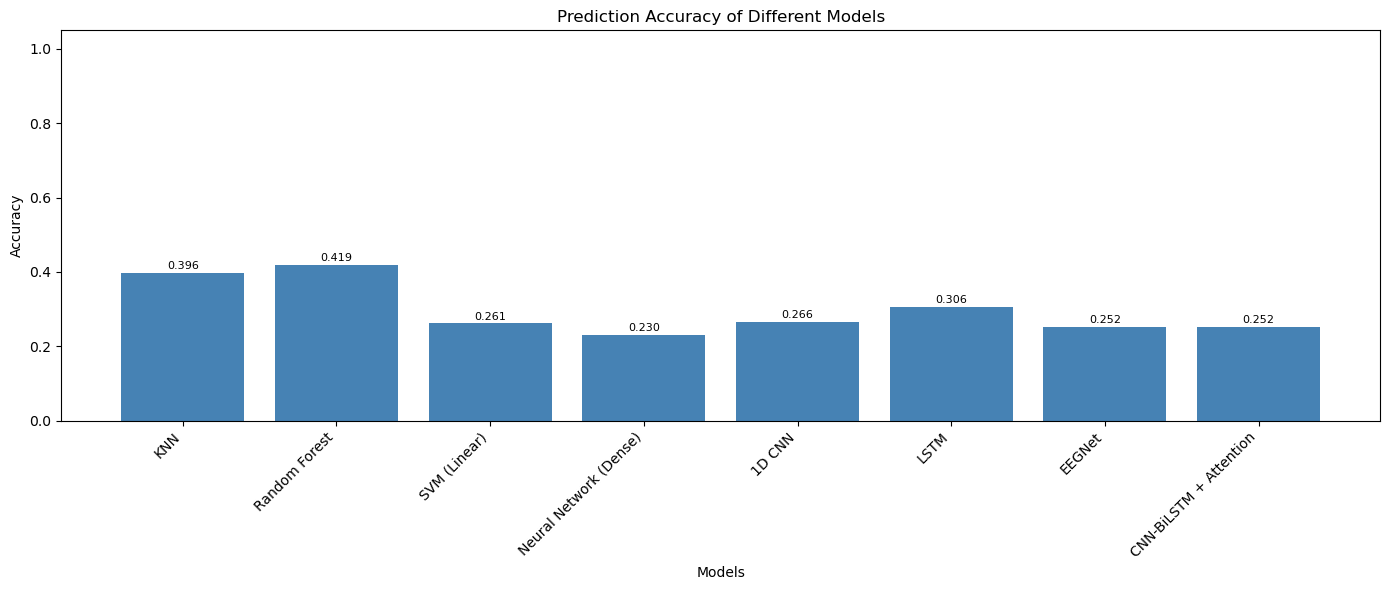

In [73]:
# Accuracy comparison across models (only include ones that exist)
model_acc = {}
for name, var in [
    ('KNN', 'knn_acc'),
    ('Random Forest', 'rf_acc'),
    ('SVM (Linear)', 'svm_acc'),
    ('Neural Network (Dense)', 'nn_acc'),
    ('1D CNN', 'cnn_acc'),
    ('LSTM', 'lstm_acc'),
    ('EEGNet', 'eegnet_acc'),
    ('CNN-BiLSTM + Attention', 'cnn_bilstm_attn_acc'),
 ]:
    if var in globals():
        model_acc[name] = float(globals()[var])

plt.figure(figsize=(14, 6))
names = list(model_acc.keys())
scores = list(model_acc.values())
bars = plt.bar(names, scores, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy of Different Models')

for b, s in zip(bars, scores):
    plt.text(b.get_x() + b.get_width()/2, s + 0.005, f'{s:.3f}', ha='center', va='bottom', fontsize=8)

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

## 7.3 Interpretation / Evaluation

In [74]:
# Interpretation / Evaluation (robust to stale variables)
if 'y_test' in globals():
    y_test_arr = np.asarray(globals()['y_test'])
elif 'y_test_arr' in globals():
    y_test_arr = np.asarray(globals()['y_test_arr'])
else:
    raise NameError('y_test not found. Run the train/test split cells first.')

labels = sorted(pd.Series(y_test_arr).unique())
target_names = [str(l) for l in labels]

def _report(name: str, y_pred):
    if y_pred is None:
        print(f"{name}: not available")
        return
    y_pred = np.asarray(y_pred)
    if len(y_pred) != len(y_test_arr):
        print(f"{name}: skipped (length mismatch y_test={len(y_test_arr)} vs y_pred={len(y_pred)})")
        return
    print(f"{name}:")
    print(classification_report(y_test_arr, y_pred, target_names=target_names, zero_division=0))
    print('------------------------------------------------------\n')

def _predict_from_keras(model_obj, X, name: str):
    if model_obj is None or X is None:
        return None
    if not hasattr(model_obj, 'predict'):
        return None
    try:
        probs = model_obj.predict(X, verbose=0)
        probs = np.asarray(probs)
        if probs.ndim == 1:
            # binary sigmoid-like output
            return (probs >= 0.5).astype(int)
        return np.argmax(probs, axis=1)
    except Exception as e:
        print(f"{name}: could not compute predictions: {e}")
        return None

# -----------------
# Classic ML models
# -----------------
_report('Logistic Regression', globals().get('y_prediction'))
_report('SVM (SVC linear)', globals().get('y_pred_svm'))
_report('Decision Tree', globals().get('y_pred_dt'))
_report('KNN', globals().get('y_pred_knn'))
_report('Naive Bayes', globals().get('y_pred_nb'))
_report('GBM', globals().get('y_pred_gbm'))
_report('FANN (MLP)', globals().get('y_pred_fann'))

# ----------------------
# Dense NN (tabular ML)
# ----------------------
dense_pred = None
if 'nn_pred' in globals() and len(np.asarray(nn_pred)) == len(y_test_arr):
    dense_pred = nn_pred
else:
    # Try to recompute using the latest Keras dense model if it exists
    if 'model' in globals() and hasattr(model, 'predict') and 'X_test_scaled' in globals():
        try:
            probs = model.predict(X_test_scaled, verbose=0)
            dense_pred = np.argmax(np.asarray(probs), axis=1)
        except Exception as e:
            print('Dense NN: could not recompute predictions:', e)
            dense_pred = None
_report('Neural Network (Dense)', dense_pred)

# -------------------------
# Deep learning (sequences)
# -------------------------
Xseq = globals().get('X_test_seq')
Xeeg = globals().get('X_test_eeg')
_report('RNN', _predict_from_keras(globals().get('rnn_model'), Xseq, 'RNN'))
_report('LSTM', _predict_from_keras(globals().get('lstm_model'), Xseq, 'LSTM'))
_report('Transformer', _predict_from_keras(globals().get('transformer_model'), Xseq, 'Transformer'))
_report('Mambular', _predict_from_keras(globals().get('mambular_model'), Xseq, 'Mambular'))
_report('CNN-BiLSTM + Attention', _predict_from_keras(globals().get('cnn_bilstm_attn_model'), Xseq, 'CNN-BiLSTM + Attention'))
_report('BERT-style Transformer', _predict_from_keras(globals().get('bert_model'), Xseq, 'BERT-style Transformer'))

# EEG-specific conv models (often use X_test_eeg if reshaped earlier)
_report('EEGNet', _predict_from_keras(globals().get('eegnet_model'), Xeeg, 'EEGNet'))
_report('DeepConvNet', _predict_from_keras(globals().get('deepconvnet_model'), Xeeg, 'DeepConvNet'))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.23      0.21      0.22        56
           1       0.31      0.29      0.30        56
           2       0.21      0.29      0.24        56
           3       0.38      0.28      0.32        54

    accuracy                           0.27       222
   macro avg       0.28      0.27      0.27       222
weighted avg       0.28      0.27      0.27       222

------------------------------------------------------

SVM (SVC linear):
              precision    recall  f1-score   support

           0       0.24      0.36      0.29        56
           1       0.36      0.27      0.31        56
           2       0.23      0.20      0.21        56
           3       0.32      0.30      0.31        54

    accuracy                           0.28       222
   macro avg       0.29      0.28      0.28       222
weighted avg       0.29      0.28      0.28       222

-----------------------------------

LSTM:
              precision    recall  f1-score   support

           0       0.32      0.23      0.27        56
           1       0.34      0.20      0.25        56
           2       0.24      0.12      0.16        56
           3       0.31      0.69      0.43        54

    accuracy                           0.31       222
   macro avg       0.30      0.31      0.28       222
weighted avg       0.30      0.31      0.28       222

------------------------------------------------------



Transformer:
              precision    recall  f1-score   support

           0       0.27      0.64      0.38        56
           1       0.00      0.00      0.00        56
           2       0.50      0.04      0.07        56
           3       0.28      0.43      0.34        54

    accuracy                           0.27       222
   macro avg       0.26      0.28      0.20       222
weighted avg       0.26      0.27      0.19       222

------------------------------------------------------

Mambular:
              precision    recall  f1-score   support

           0       0.33      0.34      0.34        56
           1       0.37      0.66      0.47        56
           2       0.15      0.05      0.08        56
           3       0.45      0.37      0.41        54

    accuracy                           0.36       222
   macro avg       0.33      0.36      0.32       222
weighted avg       0.32      0.36      0.32       222

---------------------------------------------------

# **8. Recommendation Engine**

1. Identify your Label Mapping
Based on your data cleaning, your classifications are Calm, Bored, Happy, and Scared. When you binarize or encode these for the models, they are assigned numeric values. Ensure your mapping matches your training setup:

In [75]:
# Use the mapping created during label encoding

# id_to_emotion maps numeric class IDs -> human-readable labels

if 'id_to_emotion' not in globals():

    raise NameError('Expected id_to_emotion from the label-encoding cell')



print('Using label mapping:', id_to_emotion)


Using label mapping: {0: 'Calm', 1: 'Scared', 2: 'Happy', 3: 'Bored'}


2. Extract Prediction from the Model
At the end of your notebook, you have a block that runs _predict_from_keras. You can modify that logic to extract a single "current" state for a user.

In [76]:
# Pick a sample from the test set and get a prediction using the best available model

sample_idx = 0



current_emotion = None



# Prefer a trained sequence model if available

if 'transformer_model' in globals() and 'X_test_seq' in globals():

    test_sample = X_test_seq[sample_idx : sample_idx + 1]

    prediction_probs = transformer_model.predict(test_sample, verbose=0)

    predicted_class_index = int(np.argmax(prediction_probs, axis=1)[0])

    current_emotion = id_to_emotion.get(predicted_class_index, str(predicted_class_index))

    print('Prediction source: transformer_model (sequence)')



# Else prefer the dense Keras tabular model if it exists

elif 'model' in globals() and 'X_test_scaled' in globals():

    test_sample = X_test_scaled[sample_idx : sample_idx + 1]

    prediction_probs = model.predict(test_sample, verbose=0)

    predicted_class_index = int(np.argmax(prediction_probs, axis=1)[0])

    current_emotion = id_to_emotion.get(predicted_class_index, str(predicted_class_index))

    print('Prediction source: dense Keras model (tabular)')



# Else fall back to Logistic Regression if it was fit

elif 'log_model' in globals() and 'X_test_scaled' in globals():

    test_sample = X_test_scaled[sample_idx : sample_idx + 1]

    predicted_class_index = int(log_model.predict(test_sample)[0])

    current_emotion = id_to_emotion.get(predicted_class_index, str(predicted_class_index))

    print('Prediction source: logistic regression (tabular)')



else:

    raise RuntimeError('No trained model available for recommendation step. Run the modeling cells first.')


Prediction source: transformer_model (sequence)


3. Integrated Script
Add this block at the end of your notebook to connect your classification results to the recommendation logic:

In [77]:
def get_recommendation(predicted_emotion):
    recommendations = {
        "Scared": {"target": "Calm", "suggestions": ["Deep breathing", "Lower VR brightness"]},
        "Bored": {"target": "Happy", "suggestions": ["Switch to high-intensity game", "Social VR"]},
        "Calm": {"target": "Calm", "suggestions": ["Perfect for creative building"]},
        "Happy": {"target": "Happy", "suggestions": ["Enjoy the peak experience!"]}
    }
    return recommendations.get(predicted_emotion, {"target": "N/A", "suggestions": []})

# Final Connection
advice = get_recommendation(current_emotion)

print(f"Current System State: {current_emotion}")
print(f"Goal: Shift to {advice['target']}")
print(f"Suggested Actions: {', '.join(advice['suggestions'])}")

Current System State: Calm
Goal: Shift to Calm
Suggested Actions: Perfect for creative building
